In [ ]:
!pip install scikit-learn matplotlib rasterio numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 50.5 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


              precision    recall  f1-score   support

           0       0.34      0.35      0.34      3388
           1       0.34      0.34      0.34      3337
           2       0.34      0.33      0.33      3340

    accuracy                           0.34     10065
   macro avg       0.34      0.34      0.34     10065
weighted avg       0.34      0.34      0.34     10065



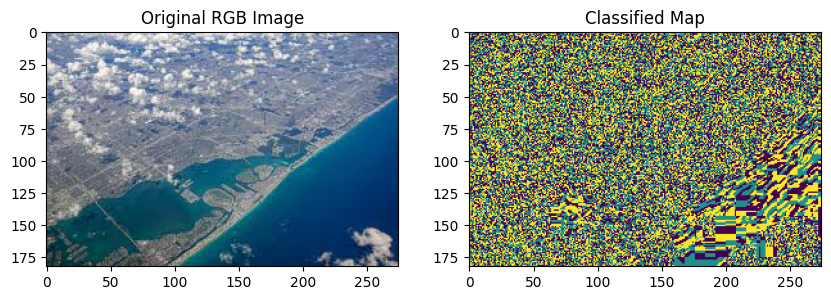

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import rasterio

# Create dummy satellite image (100x100 with 3 bands: RGB)
np.random.seed(42)
# Assuming the image has shape (bands, height, width) after reading with rasterio
try:
    with rasterio.open('/content/satellite_image.tif') as src:
        image = src.read()
        # Reshape image to (height*width, bands) for training
        X = image.transpose(1, 2, 0).reshape(-1, src.count)
        # Create dummy ground truth labels with the same number of samples as the image
        y = np.random.choice([0, 1, 2], size=(X.shape[0])) # Create labels with the same number of samples as X


except rasterio.errors.RasterioIOError:
    print("Error opening the image file. Please make sure '/content/satellite_image.tif' exists.")
    # Provide dummy data if the file doesn't exist to allow the rest of the code to run
    image = np.random.rand(100, 100, 3)
    X = image.reshape(-1, 3)
    y = np.random.choice([0, 1, 2], size=(X.shape[0])) # Create labels with the same number of samples as X

# Check for and handle non-finite values
if not np.all(np.isfinite(X)):
    print("Warning: X contains non-finite values. Replacing with 0.")
    X[~np.isfinite(X)] = 0

if not np.all(np.isfinite(y)):
    print("Warning: y contains non-finite values. Replacing with 0.")
    y[~np.isfinite(y)] = 0


# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train classifier
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))

# Predict full image and reshape to original
# Need to reshape the classified output back to the original image dimensions
if 'src' in locals(): # Use original dimensions if file was opened
    classified = clf.predict(X).reshape(src.height, src.width)
    original_image_display = image.transpose(1, 2, 0) # Transpose back for display
else: # Use dummy dimensions if file was not opened
    classified = clf.predict(X).reshape(100, 100)
    original_image_display = image


# Show original vs classified
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_image_display)
ax[0].set_title("Original RGB Image")
ax[1].imshow(classified, cmap='viridis')
ax[1].set_title("Classified Map")
plt.show()